In [69]:
import numpy as np
import pandas as pd
import os
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn
from scipy.stats import norm
from tabulate import tabulate

In [70]:
def get_close_price(ticker, period="max"):
    """Запрос исторических данных о цене закрытия по тикеру
    Варианты написания периода: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max"""
    ticker_base_info = yf.Ticker(ticker)
    hist = ticker_base_info.history(period="max")
    close = np.array(hist.iloc[:,3])
    return close

In [71]:
def calc_rate_of_return(close_prices_array):
    """Расчет доходности по акциям на основании массива цен закрытия"""
    ror = np.diff(close) / close[:-1]
    return ror

In [72]:
def calc_acc_rate_of_return(rate_of_return_array):
    """Расчет накопленной доходности на основании массива значений доходности"""
    aror = (ror + 1.).cumprod() - 1
    return aror

In [73]:
def calc_compound_annual_growth_rate(acc_rate_of_return_array):
    """Расчет среднегодовой доходности на основании массива значений накопленной доходности"""
    years_total = acc_rate_of_return_array.size / 12
    cagr = (aror[-1] + 1.) ** (1 / years_total) - 1.
    return cagr

In [74]:
def calc_risk_monthly(rate_of_return_array):
    """Расчет месячного риска на основании массива значений доходности"""
    risk_monthly = rate_of_return_array.std()
    return risk_monthly

In [75]:
def calc_risk_yearly(rate_of_return_array):
    """Расчет годового риска на основании массива значений доходности"""
    ror_mean = (1. + rate_of_return_array).mean()
    risk_monthly = calc_risk_monthly(rate_of_return_array)
    risk_yearly = np.sqrt((risk_monthly**2 + ror_mean**2)**12 - ror_mean**24)
    return risk_yearly

In [76]:
def calc_rate_of_return_p(ticker_list, weights):
    """Расчет доходности по активам портфеля"""
    ror_p = 0.0
    for i in range(weights.size):
        close = get_close_price(ticker_list[i])
        ror = calc_rate_of_return(close) * weights[i]
        ror_sum = ror.sum(axis=0)
        ror_p = ror_p + ror_sum
    return ror_p

In [77]:
def plot_var(rate_of_return_array):
    """Расчет показателя Value at Risk"""
    ror_mean = np.mean(ror)
    ror_std = np.std(ror)
    pd.Series(ror).hist(bins=40, density=True,histtype='stepfilled',alpha=0.5)
    #x = np.linespace(ror_mean - 3 * ror_std, ror_mean + 3 * ror_std, 100)
    #plt.plot(x,mlab.normpdf(x, ror_mean, ror_std),"r")
    var_90 = norm.ppf(1-0.9,ror_mean,ror_std)
    var_95 = norm.ppf(1-0.95,ror_mean,ror_std)
    var_99 = norm.ppf(1-0.99,ror_mean,ror_std)
    print(tabulate([['90%',var_90],['95%',var_95],['99%',var_99]],headers=['Confidence Level', 'Value at Risk']))
    plt.show()

In [78]:
def calc_var(rate_of_return_array, alpha = 0.95):
    sorted_df = pd.Series(rate_of_return_array).sort_values(ascending = True)
    VaR = sorted_df.quantile(q=alpha, interpolation = 'higher')
    return VaR

In [79]:
def calc_esf(rate_of_return_array, alpha = 0.95):
    sorted_df = pd.Series(rate_of_return_array).sort_values(ascending = True)
    VaR = calc_var(sorted_df, alpha = alpha )
    Multipler = 1/(len(sorted_df)*(1-alpha))
    FirstTerm = VaR
    SecondTerm = (sorted_df.searchsorted(VaR)[0]+1) - len(sorted_df)*alpha 
    #SecondTerm = 1
    ThirdTerm = sum(sorted_df[sorted_df > VaR])
    ES = Multipler *(FirstTerm * SecondTerm + ThirdTerm)
    return ES

In [80]:
def plot_aror(tickers_list, date_from, date_to):
    data = pd.DataFrame(columns=tickers_list)
    for ticker in tickers_list:
        data[ticker] = yf.download(ticker, date_from, date_to)['Adj Close']
    ((data.pct_change()+1).cumprod()-1).plot(figsize=(10, 7))
    plt.legend()
    plt.title("Расчет накопленной доходности", fontsize=16)
    plt.ylabel('Накопленная доходность', fontsize=14)
    plt.xlabel('Year', fontsize=14)
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.show()    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


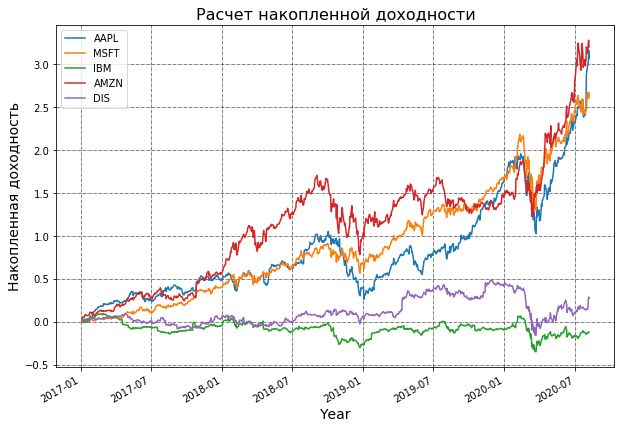

In [96]:
plot_aror(['AAPL', 'MSFT', 'IBM', 'AMZN', 'DIS'],'2017-01-01','2020-08-08')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


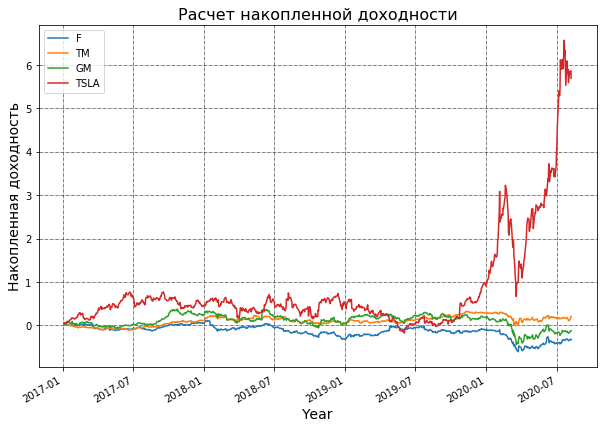

In [98]:
plot_aror(['F','TM', 'GM','TSLA'],'2017-01-01','2020-08-08')

In [68]:
# Получено на основании набора данных Pink Pages Всемирного банка
x = [25.38,27.70,27.47,22.54,27.34,29.68,28.53,29.43,32.62,30.93,32.52,25.13,25.64,27.41,24.40,25.64,28.45,27.72,24.54,25.70,25.54,20.48,18.94,18.60,19.49,20.29,23.69,25.65,25.39,24.13,25.77,26.63,28.34,27.55,24.18,28.52,31.25,32.65,30.34,25.02,25.81,27.55,28.40,29.83,27.10,29.59,28.77,29.93,31.18,30.87,33.80,33.36,37.92,35.19,38.37,43.03,43.38,49.82,43.05,39.64,44.28,45.56,53.08,51.86,48.67,54.31,57.58,64.09,62.98,58.52,55.54,56.75,63.57,59.92,62.25,70.44,70.19,68.86,73.90,73.61,62.77,58.38,58.48,62.31,54.30,57.76,62.14,67.40,67.48,71.32,77.20,70.80,77.13,82.86,92.53,91.45,91.92,94.82,103.28,110.19,123.94,133.05,133.87,113.85,99.06,72.84,53.24,41.58,44.86,43.24,46.84,50.85,57.94,68.62,64.91,72.50,67.69,73.19,77.04,74.67,76.37,74.31,79.27,84.98,76.25,74.84,74.74,76.69,77.79,82.92,85.67,91.80,96.29,103.96,114.44,123.07,114.46,113.76,116.46,110.08,110.88,109.47,110.50,107.91,111.16,119.70,124.93,120.46,110.52,95.59,103.14,113.34,113.38,111.97,109.71,109.68,112.97,116.52,109.24,102.88,103.03,103.11,107.72,110.96,111.62,109.48,108.08,110.67,107.42,108.81,107.40,107.79,109.68,111.87,106.98,101.92,97.34,87.27,78.44,62.33,48.07,57.93,55.79,59.39,64.56,62.34,55.87,46.99,47.24,48.12,44.42,37.72,30.80,33.20,39.07,42.25,47.13,48.48,45.07,46.14,46.19,49.73,46.44,54.07,54.89,55.49,51.97,52.98,50.87,46.89,48.69,51.37,55.16,57.62,62.57,64.21,68.99,65.42,66.45,71.63,76.65,75.19,74.44,73.13,78.86,80.47,65.17,56.46,59.27,64.13,66.41,71.20,70.53,63.30,64.00,59.25,62.33,59.37,62.74,65.85,63.60,55.00,32.98,23.34,31.02,39.93,42.81,44.26,41.09,40.47,43.23]
y = [34.8,33.2,34.9,37.2,32.4,31.5,31.2,30.6,28.8,25.5,25.7,26.5,25.4,24,25.4,25.1,23.4,25.5,33,36.2,31,27.7,32.3,35.95,37.38,35.298,35.9,36.007,38.491,42.613,42.222,44.609,42.476,42.724,46.502,48.852,48.611,47.695,45.355,44.302,45.382,46.621,45.772,43.936,44.091,51.507,54.8,53.972,52.723,56.413,58.352,57.505,53.717,47.12,45.477,45.814,46.809,45.126,45.461,44.62,41.886,42.263,45.813,45.786,45,45.17,45.452,44.848,45.364,46.75,46.67,45.675,45.905,47.39,47.252,47.59,48.372,47.816,49.921,53.426,51.124,51.418,57.157,62.588,63.759,64.52,66.093,74.345,81.609,83.319,85.452,83.065,85.163,92.62,99.857,100.222,112.215,126.863,137.722,132.011,132.645,129.321,121.348,96.357,82.602,63.575,58.125,58.724,65.855,65.566,66.048,79.97,87.261,78.857,69.848,74.605,70.385,72.466,76.333,82.181,83.088,83,86.283,86.271,85.531,82.568,84.443,94.373,94.888,102.583,113.136,123.464,130.357,132.721,124.174,121.961,123.012,119.238,118.345,120.548,113.725,104.475,111.338,112.15,112.35,114.625,119.534,123.361,112.5,102.774,105.284,102.238,100.138,88.6,86.318,84.355,88.452,91.958,89.15,87.417,87.947,87.688,82.709,81.929,82.625,85.966,90.405,88.625,86.263,90.434,95.381,92.663,89.842,86.188,85.369,77.869,76.075,76.44,76.475,71.964,71.964,72.304,69.886,68.275,69.735,70.591,68,60.138,59.95,63.667,60.821,60.738,61.163,67.917,71.595,77.5,75.342,71.818,67.816,77.102,79.785,74.975,76.693,81.138,82.5,80.861,77.87,75.206,76.275,73.514,72.048,71.795,75.425,74.679,72.886,67.917,70.345,70.944,70.619,70.118,68.715,65.65,61.614,61.475,60.515,58.98,53.91,53.502,58.458,60.297,57.302,58.845,56.355,55.219,54.388,58.612,58.03,59.135,68.541,76.373,81.007,72.881,63.625,60.888,57.656,65.649,69.416,76.03,79.622,81.927,91.781]

In [63]:
# Рассчитаем коэффициенты slope и intersect
x_mean =  np.mean(x)
y_mean =  np.mean(y)
slope_numerator   = sum([(x[i] - x_mean)*(y[i] - y_mean) for i in range(len(x))])
slope_denominator = sum([(x[i] - x_mean)**2 for i in range(len(x))])
slope = slope_numerator / slope_denominator
intercept = y_mean - slope * x_mean
print('Угловой коэффициент: ' + str(round(slope,2)) + '; свободный член: ' + str(round(intercept,2)))

Угловой коэффициент: 0.72; свободный член: 23.11


In [64]:
# Рассчитаем предсказанные значения Y
y_pred = [slope * x[i] + intercept for i in range(len(x))]

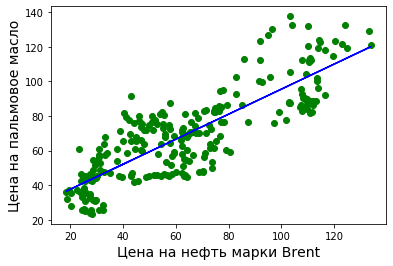

In [67]:
#Нанесем все значения на график: предсказанные и фактические
plt.scatter(x, y, c='g')
plt.plot(x, y_pred, c='b')
#plt.title("Анализ зависимости товаров по данным pink pages Всемирного банка", fontsize=16)
plt.ylabel('Цена на пальмовое масло', fontsize=14)
plt.xlabel('Цена на нефть марки Brent', fontsize=14)
plt.show()

In [23]:
tickers_list = ['AAPL', 'MSFT', 'IBM', 'UBER', 'F']
data = pd.DataFrame(columns=tickers_list)
for ticker in tickers_list:
    data[ticker] = yf.download(ticker,'2012-01-01','2020-08-08')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [89]:
close = get_close_price('TSLA','2y')
ror = calc_rate_of_return(close)

In [90]:
aror = calc_acc_rate_of_return(ror)

In [91]:
cagr = calc_compound_annual_growth_rate(aror)

In [92]:
risk_monthly = calc_risk_monthly(ror)

In [93]:
risk_yearly = calc_risk_yearly(ror)

In [94]:
print(cagr)

0.022509523468765114


In [55]:
print(risk_yearly)

0.12678541260952272


In [56]:
calc_var(ror)

0.05598608255574884

In [ ]:
calc_esf(ror)

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.042995
95%                      -0.0558888
99%                      -0.0800753


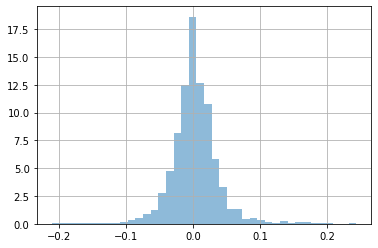

In [58]:
plot_var(ror)

In [119]:
weights = np.array([0.5,0.5])
ticker_list = ['MSFT','AAPL']
calc_rate_of_return_p(ticker_list, weights)

10.553055331073287